In [1]:
import warnings
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(0)
from tensorflow import set_random_seed
set_random_seed(0)

Using TensorFlow backend.


Load the raw data and join them together

In [2]:
category = pd.read_csv('item_categories.csv')
category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [3]:
#only took items_id under 2000 to keep the dataframe small
with gzip.open('sales_train.csv.gz', 'rb') as f:
    sales = pd.read_csv(f)

sales = sales[sales['item_id']<=2000]
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
470,07.01.2013,0,25,1359,849.50,1.00
471,03.01.2013,0,25,1261,399.00,1.00
472,24.01.2013,0,25,1362,98.00,1.00
473,22.01.2013,0,25,1266,299.00,1.00
474,24.01.2013,0,25,1268,299.00,1.00


In [4]:
shops = pd.read_csv('shops.csv')

In [5]:
items = pd.read_csv('items.csv')

In [6]:
#only took items_id under 2000 to keep the dataframe small
with gzip.open('test.csv.gz', 'rb') as f:
    test = pd.read_csv(f)

test = test[test['item_id']<=2000]
test.head()
test.shape

(16926, 3)

In [7]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(category, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
470,07.01.2013,0,25,1359,849.50,1.00,"Adidas miCoach (только для PS Move) [PS3, англ...",19,"Москва ТРК ""Атриум""",Игры - PS3
471,03.01.2013,0,25,1261,399.00,1.00,AEROSMITH The Essential 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
472,24.01.2013,0,25,1362,98.00,1.00,"Afterfall: Тень прошлого [PC, Jewel, русская в...",30,"Москва ТРК ""Атриум""",Игры PC - Стандартные издания
473,22.01.2013,0,25,1266,299.00,1.00,AGUILERA CHRISTINA Lotus,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
474,24.01.2013,0,25,1268,299.00,1.00,AL BANO Amanda E Libera,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства


To reduce computation time, only train data that is in the test set

In [8]:
test_shop_id = test['shop_id'].unique()
test_item_id = test['item_id'].unique()
train = train[train['shop_id'].isin(test_shop_id)]
train = train[train['item_id'].isin(test_item_id)]
train.shape

(91925, 10)

In [9]:
# Select only useful features.
train_monthly = train[['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date_block_num').groupby(['date_block_num','shop_id', 'item_id'])[['item_cnt_day']].sum()
train_monthly = train_monthly.reset_index()
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

train_monthly.head()

,date_block_num,shop_id,item_id,item_cnt,item_cnt_month
0,0,2,33,1.00,2.00
1,0,2,482,1.00,1.00
2,0,2,491,1.00,1.00
3,0,2,839,1.00,1.00
4,0,2,1007,3.00,1.00


In [10]:
monthly_series = pd.pivot_table(train_monthly, values='item_cnt', index=['shop_id', 'item_id'],columns=['date_block_num']).reset_index()
monthly_series.fillna(0, inplace = True)
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,31,0.00,4.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,2,32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,2,33,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00
4,2,53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [11]:
monthly_series.shape

(7417, 36)

In [12]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2.00,31.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2.00,31.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,2.00,32.00,2.00,2.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00


In [13]:
#drop item and shop id
data_series = data_series.drop(['shop_id','item_id'], axis = 1)

In [14]:
#split data into x and y and also train and validate
label = data_series['label'].values
data_series = data_series.drop('label',axis = 1)

train, valid, Y_train, Y_valid = train_test_split(data_series,label,test_size=0.10)

In [15]:
#reshaping the data, (number of batches ,number of timesteps,number of features per timestep)
X_train = train.values.reshape(train.shape[0],train.shape[1],1)
X_valid = valid.values.reshape(valid.shape[0],valid.shape[1],1)

In [16]:
#create the lstm model
time_steps = X_train.shape[1]
features = X_train.shape[2]
lr = 0.0001
epochs = 15
batch = 64

lstm_model = Sequential()
lstm_model.add(LSTM(10, input_shape = (time_steps,features), return_sequences=True))
lstm_model.add(LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(LSTM(1, activation='relu'))
lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam, metrics = ['acc'])

#fit the lstm model
lstm_history = lstm_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch, validation_data=(X_valid, Y_valid), verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 10)            480       
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 6)             408       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
__

Creating an autoencoder using LSTM model

In [17]:
time_steps = X_train.shape[1]
features = X_train.shape[2]
lr = 0.0001
epochs = 15
batch = 64

encoder_decoder = Sequential()
encoder_decoder.add(LSTM(serie_size, activation='relu', input_shape=(time_steps, features), return_sequences=True))
encoder_decoder.add(LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(1, activation='relu'))
encoder_decoder.add(RepeatVector(serie_size))
encoder_decoder.add(LSTM(serie_size, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(TimeDistributed(Dense(1)))
encoder_decoder.summary()

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mse', optimizer=adam, metrics = ['acc'])

encoder_decoder_history = encoder_decoder.fit(X_train, X_train, epochs=epochs, batch_size=batch, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
lstm_5 (LSTM)                (None, 12, 6)             456       
_________________________________________________________________
lstm_6 (LSTM)                (None, 1)                 32        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 1)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
lstm_8 (LSTM)                (None, 12, 6)             456       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 1)             7         
Total para

In [18]:
#going to build the encoding model, by modeling layer 0 to 2 from the encoder-decoder model
#the second layer has LSTM with only 1 node, so we are basically reducing 12 months (0-11) into 1 column,
# the encoded output basically summarizes month 0-11 into 1 column
#so kind of performing a dimension reduction. train_encoded and validation_encoded have only 1 column

encoder = Model(inputs = encoder_decoder.inputs, outputs = encoder_decoder.layers[2].output)

train_encoded = encoder.predict(X_train)
validation_encoded = encoder.predict(X_valid)

In [19]:
train['encoded'] = train_encoded
train['label'] = Y_train

valid['encoded'] = validation_encoded
valid['label'] = Y_valid

train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,encoded,label
2043,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
11503,6.00,7.00,4.00,6.00,5.00,3.00,6.00,3.00,1.00,4.00,3.00,1.00,0.55,1.00
6978,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
10516,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
14096,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
11060,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12309,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00
10673,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,2.00,0.08,0.00
9335,0.00,1.00,1.00,2.00,1.00,1.00,3.00,0.00,0.00,0.00,1.00,1.00,0.20,0.00


In [20]:
#create a new set of x and y arrays, this time, X will have only 2 columns, month 11 and encoded
X_train_encoded = train[[11,'encoded']]
Y_train_encoded = train[['label']]

X_valid_encoded = valid[[11,'encoded']]
Y_valid_encoded = valid[['label']]

X_train_encoded.head()

,11,encoded
2043,0.00,0.00
11503,1.00,0.55
6978,0.00,0.00
10516,0.00,0.00
3803,0.00,0.00


In [21]:
#create another keras model but this time only using the 2 features from above (month 11 and encoded)

lr = 0.0001
epochs = 15
batch = 64



mlp_model = Sequential()
mlp_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu', input_shape=(X_train_encoded.shape[1],)))
mlp_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(Dense(1))
mlp_model.summary()

adam = optimizers.Adam(lr)
mlp_model.compile(loss='mse', optimizer=adam, metrics = ['acc'])
mlp_history = mlp_model.fit(X_train_encoded.values, Y_train_encoded.values, epochs=epochs, batch_size=batch, validation_data=(X_valid_encoded, Y_valid_encoded), verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
Train on 13350 samples, validate on 1484 samples
Epoch 1/15
 - 2s - loss: 4.6748 - acc: 0.7432 - val_loss: 4.8890 - val_acc: 0.7412
Epoch 2/15
 - 1s - loss: 4.5839 - acc: 0.7432 - val_loss: 4.8286 - val_acc: 0.7412
Epoch 3/15
 - 0s - loss: 4.4943 - acc: 0.7432 - val_loss: 4.7732 - val_acc: 0.7412
Epoch 4/15
 - 0s - loss: 4.4140 - acc: 0.7433 - val_loss: 4.7235 - val_acc: 0.7412
Epoch 5/15
 - 0s - loss: 4.

Text(0.5, 1.0, 'Encoded Features LSTM Model')

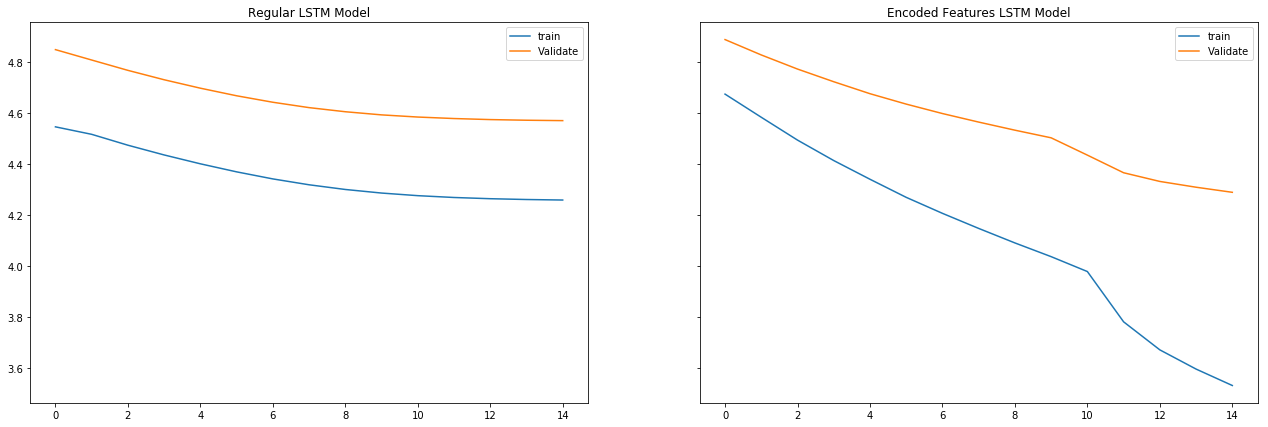

In [22]:
#plot the loss and val_loss for both the models
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(22,7), sharey=True)
ax1.plot(lstm_history.history['loss'], label='train')
ax1.plot(lstm_history.history['val_loss'], label='Validate')
ax1.legend()
ax1.set_title('Regular LSTM Model')

ax2.plot(mlp_history.history['loss'], label='train')
ax2.plot(mlp_history.history['val_loss'], label='Validate')
ax2.legend()
ax2.set_title('Encoded Features LSTM Model')

In [23]:
#calculate the RMSE error for regular lstm model vs encoded features lstm model
#based on the RMSE, the encoded features has a lower error

Y_train_pred = lstm_model.predict(X_train)
Y_train_encoded_pred = mlp_model.predict(X_train_encoded.values)

print('Train rmse regular LSTM:', np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
print('Validation rmse LSTM with Encoded Features:', np.sqrt(mean_squared_error(Y_train_encoded, Y_train_encoded_pred)))

Train rmse regular LSTM: 2.0635450933616934
Validation rmse LSTM with Encoded Features: 1.8699181962084352


In [24]:
#bring back the test dataset from the beginning, merge it with the pivot table data (monthly_series)
latest_records = monthly_series.drop_duplicates(subset=['shop_id', 'item_id'])
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['ID', 'item_id', 'shop_id'], axis=1, inplace=True)
X_test.fillna(0,inplace = True)

#only take the last 12 months, month 22-33
X_test = X_test.iloc[:,22:]
print(X_test.head())

#reshape X_test so it can fit into the lstm models

X_test_reshaped  = X_test.values.reshape(X_test.shape[0],X_test.shape[1], 1)

    22   23   24   25   26   27   28   29   30   31   32   33
0 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
2 0.00 0.00 0.00 0.00 5.00 3.00 0.00 1.00 0.00 2.00 2.00 0.00
3 0.00 1.00 0.00 4.00 2.00 1.00 0.00 2.00 0.00 2.00 0.00 1.00
4 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00


In [25]:
#predict the X_test with the first LSTM Model.

lstm_test_pred  = lstm_model.predict(X_test_reshaped)

#predict the X_test with the encoded features lstm model
#first, need to encode those 12 months into 1 column
test_encoded = encoder.predict(X_test_reshaped)
X_test['encoded'] = test_encoded
#then, select month 33 and encoded features to feed into the lstm model
X_test_encoded  = X_test[[33,'encoded']]
#make the prediction
mlp_test_pred = mlp_model.predict(X_test_encoded)

In [26]:
#to link it back to the test id, X_test and test both have the same ID because we left joined test with latest_records
#meaning, all the test row were reserved to the X_test (which was used to train the model)
mlp_prediction = pd.DataFrame(test['ID'], columns=['ID'])
mlp_prediction['item_cnt_month - month 34'] = mlp_test_pred.clip(0., 20.)
mlp_prediction.to_csv('mlp_submission.csv', index=False)
mlp_prediction.head(10)

,ID,item_cnt_month - month 34
410,410,0.36
457,457,0.36
458,458,0.53
459,459,0.74
478,478,0.36
493,493,0.36
495,495,0.36
496,496,0.36
497,497,0.36
498,498,3.63
